In [28]:
import os
import time

import torch
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import functional as F
from datetime import datetime

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [29]:
df_train = pd.read_csv('../UNSW-NB15/UNSW_NB15_training-set.csv')
df_test = pd.read_csv('../UNSW-NB15/UNSW_NB15_testing-set.csv')
df = pd.concat([df_train, df_test])
df = df.drop(['id', 'label'], axis=1)

In [30]:
number_col = df.select_dtypes(include=['number']).columns
cat_col = df.columns.difference(number_col)
cat_col = cat_col.drop('attack_cat')
df_cat = df[cat_col].copy()

In [31]:
# one-hot编码
one_hot_data = pd.get_dummies(df_cat, columns=cat_col)

# 将原数据的分类变量去掉
one_hot_df = pd.concat([df, one_hot_data],axis=1)
one_hot_df.drop(columns=cat_col, inplace=True)

In [32]:
minmax_scale = MinMaxScaler(feature_range=(0, 1))

def normalization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = minmax_scale.fit_transform(arr.reshape(len(arr),1))
    return df

In [33]:
normalized_df = normalization(one_hot_df.copy(), number_col)

In [34]:
# 为不同的类别进行编码
labels = pd.DataFrame(df.attack_cat)
label_encoder = LabelEncoder()
enc_label = labels.apply(label_encoder.fit_transform)
normalized_df.attack_cat = enc_label
label_encoder.classes_

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

In [35]:
data = normalized_df

In [36]:
X = data.drop(columns=['attack_cat'])
y = data['attack_cat']
X_train = X[0:df_train.shape[0]]
y_train = y[0:df_train.shape[0]]
X_test = X[df_train.shape[0]:]
y_test = y[df_train.shape[0]:]

In [37]:
class LoadData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = torch.tensor(self.X.iloc[index])
        y = torch.tensor(self.y.iloc[index])
        return X, y

In [38]:
train_data = LoadData(X_train, y_train)
test_data = LoadData(X_test, y_test)
X_dimension = len(X_train.columns)
y_dimension = len(y_train.value_counts())

In [39]:
batch_size = 256

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [40]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [41]:
def train(model, optimizer, loss_fn, epochs):

    losses = []
    iter = 0

    for epoch in range(epochs):
        print(f"epoch {epoch+1}\n-----------------")
        for i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
            X = X.reshape(X.shape[0], 1, X_dimension)
            y_pred = model(X)
            loss = loss_fn(y_pred, y.long())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f"loss: {loss.item()}\t[{(i+1)*len(X)}/{len(train_data)}]")

                iter += 1
                losses.append(loss.item())

    return losses, iter

In [42]:
def test(model):
    positive = 0
    negative = 0
    with torch.no_grad():
        iter = 0
        loss_sum = 0
        for X, y in test_dataloader:
            X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
            X = X.reshape(X.shape[0], 1, X_dimension)
            y_pred = model(X)
            # print(f"y_pred: {y_pred.shape}, y: {y.shape}")
            loss = loss_fn(y_pred, y.long())
            loss_sum += loss.item()
            iter += 1
            for item in zip(y_pred, y):
                if torch.argmax(item[0]) == item[1]:
                    positive += 1
                else:
                    negative += 1
    acc = positive / (positive + negative)
    avg_loss = loss_sum / iter
    print("Accuracy:", acc)
    print("Average Loss:", avg_loss)

In [43]:
def loss_value_plot(losses, iter):
    plt.figure()
    plt.plot([i for i in range(1, iter+1)], losses)
    plt.xlabel('Iterations (×100)')
    plt.ylabel('Loss Value')

### DNN

In [44]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(X_dimension, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, y_dimension)
        )

    def forward(self, X):
        X = self.flatten(X)
        logits = self.network(X)
        return logits

In [45]:
DNN_model = DNN()
DNN_model.to(device=device)

DNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=196, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [46]:
# 超参数
is_trained = False
epochs = 1
lr = 0.05
momentum = 0.9
optimizer = torch.optim.SGD(DNN_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

epoch 1
-----------------
loss: 2.3162660598754883	[256/175341]


loss: 0.010824651457369328	[25856/175341]
loss: 2.359840154647827	[51456/175341]
loss: 1.6743067502975464	[77056/175341]
loss: 1.6228532791137695	[102656/175341]
loss: 1.0944522619247437	[128256/175341]
loss: 0.29347360134124756	[153856/175341]


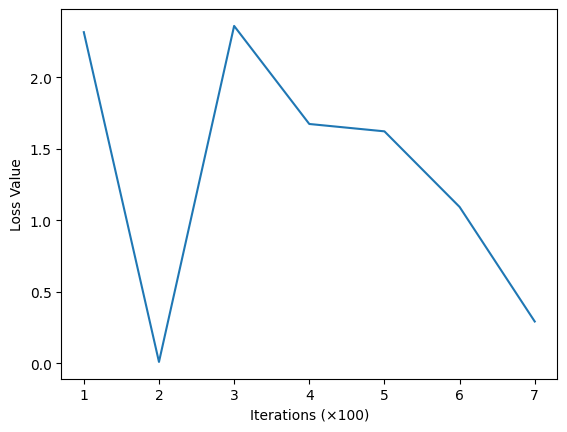

In [47]:
path = './UNSW-NB15/'
timestamp = datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S_')
old_model_name = ''
new_model_name = timestamp + 'DNN_model.pth'

if old_model_name != '':
    DNN_model.load_state_dict(torch.load(old_model_name))
else:
    losses, iter = train(DNN_model, optimizer, loss_fn, epochs)
    torch.save(DNN_model.state_dict(), path + new_model_name)

    loss_value_plot(losses, iter)
    plt.savefig(path + timestamp + 'DNN_loss.png')

In [58]:
test(DNN_model)

Accuracy: 0.3836661322450566
Average Loss: 2.467819094707067


### CNN

In [48]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv1d(1, 5, kernel_size=4),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(5, 12, kernel_size=4),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(12, 18, kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(810, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, y_dimension)
        )

    def forward(self, X):
        X = self.backbone(X)
        X = self.flatten(X)
        logits = self.fc(X)
        return logits

In [49]:
CNN_model = CNN()
CNN_model.to(device=device)

CNN(
  (backbone): Sequential(
    (0): Conv1d(1, 5, kernel_size=(4,), stride=(1,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv1d(5, 12, kernel_size=(4,), stride=(1,))
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(12, 18, kernel_size=(2,), stride=(1,))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=810, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [50]:
epochs = 1
lr = 0.001
momentum = 0.9
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

epoch 1
-----------------
loss: 2.1994504928588867	[256/175341]
loss: 0.0	[25856/175341]
loss: 2.2970962524414062	[51456/175341]
loss: 1.686957597732544	[77056/175341]
loss: 1.879929542541504	[102656/175341]
loss: 0.8921555876731873	[128256/175341]
loss: 0.285339891910553	[153856/175341]


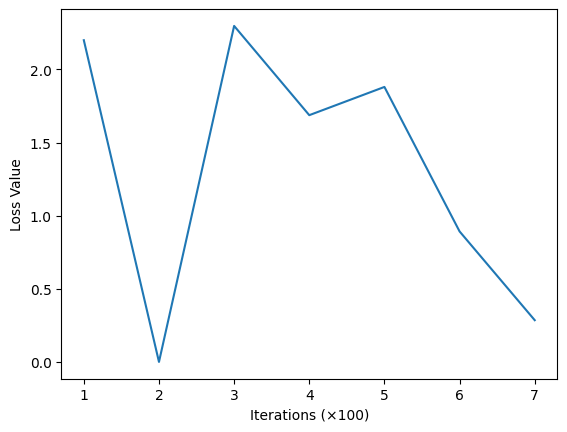

In [51]:
path = './UNSW-NB15/'
timestamp = datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S_')
old_model_name = ''
new_model_name = timestamp + 'CNN_model.pth'

if old_model_name != '':
    CNN_model.load_state_dict(torch.load(old_model_name))
else:
    losses, iter = train(CNN_model, optimizer, loss_fn, epochs)
    torch.save(CNN_model.state_dict(), path + new_model_name)

    loss_value_plot(losses, iter)
    plt.savefig(path + timestamp + 'CNN_loss.png')

In [52]:
test(CNN_model)

Accuracy: 0.3472890249234805
Average Loss: 3.9691936426553065


## resnet

In [53]:
class Residual(nn.Module): 
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b1 = nn.Sequential(nn.Conv1d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm1d(64), nn.ReLU(),
                   nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
b6 = nn.Sequential(*resnet_block(512, 1024, 2))

resnet_model = nn.Sequential(b1, b2, b3, b4, b5, b6,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(1024, y_dimension))
resnet_model.to(device=device)

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True,

In [54]:
X = torch.rand(size=(1, 1, 224), device = device)
for layer in resnet_model:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56])
Sequential output shape:	 torch.Size([1, 64, 56])
Sequential output shape:	 torch.Size([1, 128, 28])
Sequential output shape:	 torch.Size([1, 256, 14])
Sequential output shape:	 torch.Size([1, 512, 7])
Sequential output shape:	 torch.Size([1, 1024, 4])
AdaptiveAvgPool1d output shape:	 torch.Size([1, 1024, 1])
Flatten output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


In [55]:
is_trained = False
epochs = 1
lr = 1e-3 
momentum = 0.9
optimizer = torch.optim.SGD(resnet_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

epoch 1
-----------------
loss: 1.6646496057510376	[256/175341]
loss: 0.01058264635503292	[25856/175341]
loss: 1.6842453479766846	[51456/175341]
loss: 1.2153640985488892	[77056/175341]
loss: 0.9863457679748535	[102656/175341]
loss: 0.5725081562995911	[128256/175341]
loss: 0.2292562872171402	[153856/175341]


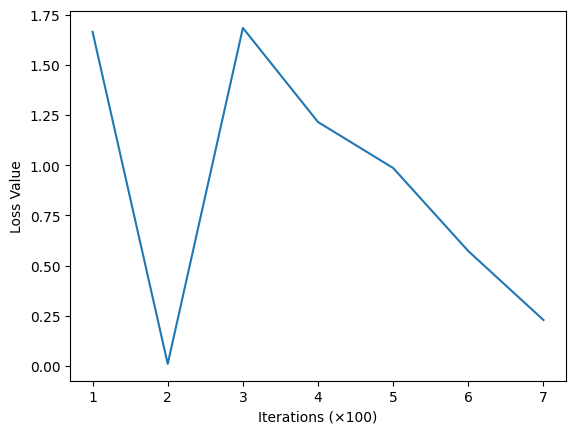

In [56]:
path = './UNSW-NB15/'
timestamp = datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H%M%S_')
old_model_name = ''
new_model_name = timestamp + 'resnet_model.pth'

if old_model_name != '':
    resnet_model.load_state_dict(torch.load(old_model_name))
else:
    losses, iter = train(resnet_model, optimizer, loss_fn, epochs)
    torch.save(resnet_model.state_dict(), path + new_model_name)

    loss_value_plot(losses, iter)
    plt.savefig(path + timestamp + 'resnet_loss.png')

In [57]:
test(resnet_model)

Accuracy: 0.27785065345187776
Average Loss: 2.761763032479501
